In [11]:
#check cuda version 
!nvcc --version 
# install pytorch according to the cuda version from the pytorch website
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
# install mmcv
!pip install mmcv-full==1.1.4
#clone github repository
!git clone https://github.com/rubeea/focal_phi_loss_mmsegmentation.git 
#install all requirements
!pip install -qr focal_phi_loss_mmsegmentation/requirements.txt 
%cd /content/focal_phi_loss_mmsegmentation
#install mmsegmentation in develop mode
!python setup.py develop 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mmcv-full-1.1.4.tar.gz (239 kB)
  Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
  Created wheel for mmcv-full: filename=mmcv_full-1.1.4-cp37-cp37m-linux_x86_64.whl size=17265597 sha256=2650376d3d1897fcade5b100a782e458b170005b305918d88d54dcbebd826e71
  Stored in directory: /root/.cache/pip/wheels/03/ee/14/19a07c6fea423e998f2159c4deac1b7a440c7d7f00bdcc48d4
Successfully built mmcv-full
Cloning into 'focal_phi_loss_mmsegmentation'...
remote: Enumerating objects: 2112, done.
remote: Counting objects: 100% (37

# Make data directories and upload the data in them

In [12]:
#declare global variables
root_dir= '/content/focal_phi_loss_mmsegmentation/data/'
data_root= "/content/drive/MyDrive/Colab_Dataset/"
dataset= "ground_truth4_renkli_oneClass"
#dataset= "mendeley"

In [13]:
import os

#script to extract data from zip files and create the directory structure for mendeley
#!python /content/focal_phi_loss_mmsegmentation/tools/convert_datasets/mendeley.py /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_gt.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_gt.zip 

#check file counts
train_imgs= data_root + dataset+'/img_dir/train'
val_imgs= data_root + dataset +'/img_dir/val'
train_gt= data_root + dataset+'/ann_dir/train'
val_gt= data_root + dataset+'/ann_dir/val'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_gt)))
print(len(os.listdir(val_gt)))

7
3
7
3


#Visualize training and mask images


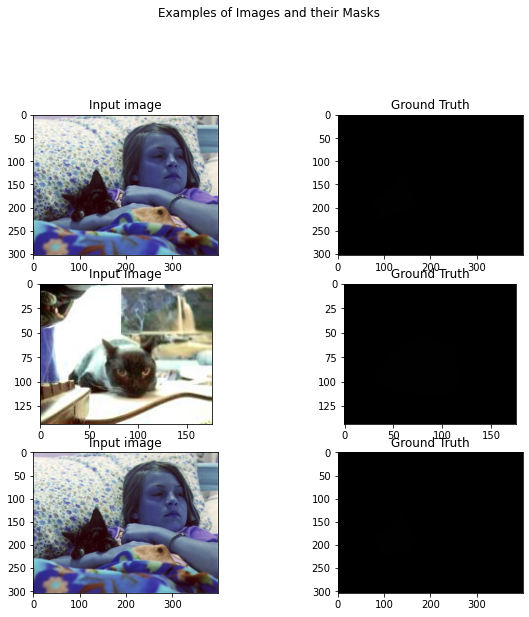

In [15]:
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob


PATH_TO_TRAIN_IMAGES_DIR= data_root+dataset+"/img_dir/train"
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/ann_dir/train"
TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

palette = [[120, 120, 120], [6, 230, 230]] #dataset palette

display_num = 5
r_choices = np.random.choice(len(TRAIN_IMAGE_PATHS), display_num)

#visualize any 5 random images and their mask images
plt.figure(figsize=(10, 15))
for i in range(0, display_num, 2):
  img_num = r_choices[i // 2]
  img = mmcv.imread(TRAIN_IMAGE_PATHS[img_num])
  label = mmcv.imread(LABEL_PATHS[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(img)
  plt.title("Input image")

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(label)
  plt.title("Ground Truth")


plt.suptitle("Examples of Images and their Masks")
plt.show()

#Create a config file


In [16]:
#config for ACU-Net
from mmcv import Config
cfg = Config.fromfile('/content/focal_phi_loss_mmsegmentation/configs/unet/fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py')

In [17]:
from mmseg.apis import set_random_seed
import torch

cfg_data_root = data_root+dataset
train_img_dir = 'img_dir/train'
train_ann_dir = 'ann_dir/train'
val_img_dir = 'img_dir/val'
val_ann_dir = 'ann_dir/val'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode head
cfg.model.decode_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'MendeleyDataset'
cfg.data_root = cfg_data_root

#batch size
cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2


#Balanced CE loss
#assign class weights to tackle the imbalanced nature of the dataset in balanced CE loss
# weights = [0.02, 0.98]
# cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, 
#                                             loss_weight=1.0, class_weight= weights)

#Dice Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.5, beta=0.5, gamma=1.0, use_focal=False, loss_weight=1.0)

#Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=1.0, use_focal=False, loss_weight=1.0)

#Focal Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=0.75, use_focal=True, loss_weight=1.0)

#MCC loss
# cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=1.0)

#Focal Phi Loss
cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=0.5)

#normalizing the dataset
cfg.img_norm_cfg = dict(
    mean= [142.393, 137.978, 83.073], std= [23.228, 20.046, 21.623], to_rgb=True) #for mendeley dataset

cfg.crop_size = (256, 256)

#dataset config
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 1.5)), #for mendeley dataset
    dict(type='RandomRotate', prob=0.5, degree=(45.0,315.0),pad_val=0,seg_pad_val=255), #for pldu and mendeley dataset
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale= (512, 512), #for mendeley dataset
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = train_img_dir
cfg.data.train.ann_dir = train_ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = None

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = val_img_dir
cfg.data.val.ann_dir = val_ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = None

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = val_img_dir
cfg.data.test.ann_dir = val_ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = None


# Set up working dir to save files and logs.
cfg.work_dir = root_dir+'/work_dirs/tutorial'

cfg.total_iters = 160
cfg.log_config.interval = 50
cfg.evaluation.interval = 200 #validation at every 200 iterations
cfg.checkpoint_config.interval = 200

# Set seed to facilitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

#for Dice Loss, Tversky Loss and Focal Tversky Loss on Mendeley dataset use the following learning rates with Adam:
# lr = 5e-5

cfg.optimizer = dict(type='Adam', lr=1e-3, weight_decay=0.0001,
                     paramwise_cfg = dict(
                        custom_keys={
                            'head': dict(lr_mult=10.)
                        }
                        ))


# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

/usr/local/lib/python3.7/dist-packages/mmcv/utils/registry.py:64: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '


Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='PhiLoss', lo

#Train the model according to the config


In [18]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmseg.utils import collect_env, get_root_logger
import mmcv
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]


meta = dict()
    # log env info
env_info_dict = collect_env()
env_info = '\n'.join([f'{k}: {v}' for k, v in env_info_dict.items()])
meta['env_info'] = env_info

meta['seed'] = cfg.seed
meta['exp_name'] = osp.basename(cfg.filename)
cfg.checkpoint_config.meta = dict(
            CLASSES=datasets[0].CLASSES,
            PALETTE=datasets[0].PALETTE)

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=meta)

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2022-07-20 11:17:25,370 - mmseg - INFO - Loaded 7 images
2022-07-20 11:17:29,198 - mmseg - INFO - Loaded 3 images
2022-07-20 11:17:29,206 - mmseg - INFO - Start running, host: root@39f63f7943b4, work_dir: /content/focal_phi_loss_mmsegmentation/data/work_dirs/tutorial
2022-07-20 11:17:29,207 - mmseg - INFO - workflow: [('train', 1)], max: 20000 iters
2022-07-20 11:17:48,318 - mmseg - INFO - Iter [50/20000]	lr: 9.980e-04, eta: 1:31:51, time: 0.276, data_time: 0.001, memory: 1552, decode.loss_seg: 0.7421, decode.acc_seg: 49.0689, loss: 0.7421
2022-07-20 11:17:58,032 - mmseg - INFO - Iter [100/20000]	lr: 9.960e-04, eta: 1:18:01, time: 0.194, data_time: 0.003, memory: 1552, decode.loss_seg: 0.7082, decode.acc_seg: 49.8793, loss: 0.7082
2022-07-20 11:18:07,678 - mmseg - INFO - Iter [150/20000]	lr: 9.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 1.7 task/s, elapsed: 2s, ETA:     0s

2022-07-20 11:18:25,360 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.01       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.97      50.00                 0.01                55.93      38.82       0.00     100.00       6.67      93.33

2022-07-20 11:18:25,364 - mmseg - INFO - Iter(val) [200]	mIoU: 0.1941, mDice: 0.2797, mAcc: 0.5000, plDice: 0.0085, bgDice: 55.9297, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0.0667, Precision: 0.9333
2022-07-20 11:18:35,158 - mmseg - INFO - Iter [250/20000]	lr: 9.899e-04, eta: 1:05:19, time: 0.329, data_time: 0.136, memory: 1552, decode.loss_seg: 0.7093, decode.acc_seg: 51.4745, loss: 0.7093
2022-07-20 11:18:44,891 - mmseg - INFO - Iter [300/20000]	lr: 9.879e-04, eta: 1:04:57, time:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:19:08,774 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:19:08,782 - mmseg - INFO - Iter(val) [400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:19:18,872 - mmseg - INFO - Iter [450/20000]	lr: 9.818e-04, eta: 0:59:26, time: 0.254, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 53.6837, loss: 0.7085
2022-07-20 11:19:29,068 - mmseg - INFO - Iter [500/20000]	lr: 9.798e-04, eta: 0:59:59, time: 0.204, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:19:53,544 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:19:53,552 - mmseg - INFO - Iter(val) [600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:20:03,895 - mmseg - INFO - Iter [650/20000]	lr: 9.737e-04, eta: 0:57:17, time: 0.259, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 52.3990, loss: 0.7086
2022-07-20 11:20:14,079 - mmseg - INFO - Iter [700/20000]	lr: 9.716e-04, eta: 0:57:44, time: 0.204, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:20:38,415 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:20:38,418 - mmseg - INFO - Iter(val) [800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:20:48,804 - mmseg - INFO - Iter [850/20000]	lr: 9.655e-04, eta: 0:55:50, time: 0.260, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 54.7664, loss: 0.7084
2022-07-20 11:20:59,123 - mmseg - INFO - Iter [900/20000]	lr: 9.635e-04, eta: 0:56:14, time: 0.206, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:21:23,654 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:21:23,657 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:21:23,659 - mmseg - INFO - Iter(val) [1000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:21:33,902 - mmseg - INFO - Iter [1050/20000]	lr: 9.574e-04, eta: 0:54:49, time: 0.256, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7082, decode.acc_seg: 50.8202, loss: 0.7082
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:22:08,453 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:22:08,458 - mmseg - INFO - Iter(val) [1200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:22:18,754 - mmseg - INFO - Iter [1250/20000]	lr: 9.493e-04, eta: 0:53:56, time: 0.258, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7081, decode.acc_seg: 52.3461, loss: 0.7081
2022-07-20 11:22:28,815 - mmseg - INFO - Iter [1300/20000]	lr: 9.472e-04, eta: 0:54:08, time: 0.201,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:22:52,733 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:22:52,737 - mmseg - INFO - Iter(val) [1400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:23:02,782 - mmseg - INFO - Iter [1450/20000]	lr: 9.411e-04, eta: 0:52:58, time: 0.253, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7087, decode.acc_seg: 54.2411, loss: 0.7087
2022-07-20 11:23:12,620 - mmseg - INFO - Iter [1500/20000]	lr: 9.391e-04, eta: 0:53:05, time: 0.197,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:23:36,453 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:23:36,459 - mmseg - INFO - Iter(val) [1600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:23:46,442 - mmseg - INFO - Iter [1650/20000]	lr: 9.329e-04, eta: 0:52:04, time: 0.252, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7088, decode.acc_seg: 52.8725, loss: 0.7088
2022-07-20 11:23:56,494 - mmseg - INFO - Iter [1700/20000]	lr: 9.309e-04, eta: 0:52:12, time: 0.201,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:24:20,121 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:24:20,128 - mmseg - INFO - Iter(val) [1800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:24:30,262 - mmseg - INFO - Iter [1850/20000]	lr: 9.248e-04, eta: 0:51:18, time: 0.255, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7083, decode.acc_seg: 52.5708, loss: 0.7083
2022-07-20 11:24:40,272 - mmseg - INFO - Iter [1900/20000]	lr: 9.227e-04, eta: 0:51:24, time: 0.200,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:25:03,995 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:25:04,000 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:25:04,005 - mmseg - INFO - Iter(val) [2000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:25:14,064 - mmseg - INFO - Iter [2050/20000]	lr: 9.166e-04, eta: 0:50:32, time: 0.254, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7090, decode.acc_seg: 53.7978, loss: 0.7090
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:25:48,006 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:25:48,009 - mmseg - INFO - Iter(val) [2200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:25:57,948 - mmseg - INFO - Iter [2250/20000]	lr: 9.084e-04, eta: 0:49:48, time: 0.250, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7093, decode.acc_seg: 52.5438, loss: 0.7093
2022-07-20 11:26:08,105 - mmseg - INFO - Iter [2300/20000]	lr: 9.063e-04, eta: 0:49:53, time: 0.203,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:26:32,104 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:26:32,106 - mmseg - INFO - Iter(val) [2400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:26:42,316 - mmseg - INFO - Iter [2450/20000]	lr: 9.002e-04, eta: 0:49:10, time: 0.257, data_time: 0.056, memory: 1552, decode.loss_seg: 0.7081, decode.acc_seg: 51.7619, loss: 0.7081
2022-07-20 11:26:52,304 - mmseg - INFO - Iter [2500/20000]	lr: 8.981e-04, eta: 0:49:13, time: 0.200,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:27:16,183 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:27:16,185 - mmseg - INFO - Iter(val) [2600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:27:26,226 - mmseg - INFO - Iter [2650/20000]	lr: 8.920e-04, eta: 0:48:29, time: 0.253, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 51.5596, loss: 0.7086
2022-07-20 11:27:35,992 - mmseg - INFO - Iter [2700/20000]	lr: 8.899e-04, eta: 0:48:29, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:27:59,831 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:27:59,833 - mmseg - INFO - Iter(val) [2800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:28:09,722 - mmseg - INFO - Iter [2850/20000]	lr: 8.837e-04, eta: 0:47:48, time: 0.249, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 49.3690, loss: 0.7086
2022-07-20 11:28:19,741 - mmseg - INFO - Iter [2900/20000]	lr: 8.817e-04, eta: 0:47:49, time: 0.200,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:28:43,166 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:28:43,170 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:28:43,174 - mmseg - INFO - Iter(val) [3000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:28:53,264 - mmseg - INFO - Iter [3050/20000]	lr: 8.755e-04, eta: 0:47:09, time: 0.253, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7085, decode.acc_seg: 51.7748, loss: 0.7085
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:29:26,765 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:29:26,768 - mmseg - INFO - Iter(val) [3200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:29:36,735 - mmseg - INFO - Iter [3250/20000]	lr: 8.673e-04, eta: 0:46:30, time: 0.251, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 52.0820, loss: 0.7084
2022-07-20 11:29:46,479 - mmseg - INFO - Iter [3300/20000]	lr: 8.652e-04, eta: 0:46:29, time: 0.195,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:30:10,242 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:30:10,245 - mmseg - INFO - Iter(val) [3400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:30:20,112 - mmseg - INFO - Iter [3450/20000]	lr: 8.590e-04, eta: 0:45:51, time: 0.249, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7090, decode.acc_seg: 51.7422, loss: 0.7090
2022-07-20 11:30:30,145 - mmseg - INFO - Iter [3500/20000]	lr: 8.570e-04, eta: 0:45:51, time: 0.201,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:30:53,875 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:30:53,877 - mmseg - INFO - Iter(val) [3600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:31:04,055 - mmseg - INFO - Iter [3650/20000]	lr: 8.508e-04, eta: 0:45:16, time: 0.255, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7105, decode.acc_seg: 54.8949, loss: 0.7105
2022-07-20 11:31:14,054 - mmseg - INFO - Iter [3700/20000]	lr: 8.487e-04, eta: 0:45:15, time: 0.200,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:31:37,852 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:31:37,855 - mmseg - INFO - Iter(val) [3800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:31:47,934 - mmseg - INFO - Iter [3850/20000]	lr: 8.425e-04, eta: 0:44:40, time: 0.254, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7087, decode.acc_seg: 52.5665, loss: 0.7087
2022-07-20 11:31:57,735 - mmseg - INFO - Iter [3900/20000]	lr: 8.404e-04, eta: 0:44:38, time: 0.196,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:32:21,738 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:32:21,742 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:32:21,747 - mmseg - INFO - Iter(val) [4000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:32:31,687 - mmseg - INFO - Iter [4050/20000]	lr: 8.342e-04, eta: 0:44:03, time: 0.251, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7082, decode.acc_seg: 54.3803, loss: 0.7082
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:33:05,561 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:33:05,564 - mmseg - INFO - Iter(val) [4200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:33:15,728 - mmseg - INFO - Iter [4250/20000]	lr: 8.259e-04, eta: 0:43:30, time: 0.256, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7084, decode.acc_seg: 52.3011, loss: 0.7084
2022-07-20 11:33:25,841 - mmseg - INFO - Iter [4300/20000]	lr: 8.239e-04, eta: 0:43:28, time: 0.202,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:33:49,694 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:33:49,696 - mmseg - INFO - Iter(val) [4400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:33:59,780 - mmseg - INFO - Iter [4450/20000]	lr: 8.176e-04, eta: 0:42:55, time: 0.253, data_time: 0.054, memory: 1552, decode.loss_seg: 0.7086, decode.acc_seg: 53.9973, loss: 0.7086
2022-07-20 11:34:09,884 - mmseg - INFO - Iter [4500/20000]	lr: 8.155e-04, eta: 0:42:53, time: 0.202,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:34:34,122 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:34:34,125 - mmseg - INFO - Iter(val) [4600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:34:44,221 - mmseg - INFO - Iter [4650/20000]	lr: 8.093e-04, eta: 0:42:21, time: 0.254, data_time: 0.055, memory: 1552, decode.loss_seg: 0.7089, decode.acc_seg: 50.7654, loss: 0.7089
2022-07-20 11:34:54,336 - mmseg - INFO - Iter [4700/20000]	lr: 8.072e-04, eta: 0:42:19, time: 0.202,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 5.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:35:18,238 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:35:18,241 - mmseg - INFO - Iter(val) [4800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:35:28,574 - mmseg - INFO - Iter [4850/20000]	lr: 8.010e-04, eta: 0:41:48, time: 0.258, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7090, decode.acc_seg: 53.2036, loss: 0.7090
2022-07-20 11:35:38,640 - mmseg - INFO - Iter [4900/20000]	lr: 7.989e-04, eta: 0:41:46, time: 0.202,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:36:02,660 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:36:02,663 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:36:02,667 - mmseg - INFO - Iter(val) [5000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:36:12,737 - mmseg - INFO - Iter [5050/20000]	lr: 7.927e-04, eta: 0:41:14, time: 0.253, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7090, decode.acc_seg: 52.3221, loss: 0.7090
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:36:47,057 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:36:47,060 - mmseg - INFO - Iter(val) [5200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:36:57,134 - mmseg - INFO - Iter [5250/20000]	lr: 7.843e-04, eta: 0:40:41, time: 0.254, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 52.4825, loss: 0.7087
2022-07-20 11:37:07,658 - mmseg - INFO - Iter [5300/20000]	lr: 7.822e-04, eta: 0:40:39, time: 0.210,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:37:32,131 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:37:32,137 - mmseg - INFO - Iter(val) [5400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:37:42,568 - mmseg - INFO - Iter [5450/20000]	lr: 7.760e-04, eta: 0:40:10, time: 0.263, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7084, decode.acc_seg: 51.9184, loss: 0.7084
2022-07-20 11:37:52,798 - mmseg - INFO - Iter [5500/20000]	lr: 7.739e-04, eta: 0:40:07, time: 0.205,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:38:17,219 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:38:17,224 - mmseg - INFO - Iter(val) [5600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:38:27,720 - mmseg - INFO - Iter [5650/20000]	lr: 7.676e-04, eta: 0:39:38, time: 0.262, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7077, decode.acc_seg: 52.3610, loss: 0.7077
2022-07-20 11:38:37,791 - mmseg - INFO - Iter [5700/20000]	lr: 7.655e-04, eta: 0:39:34, time: 0.201,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:39:02,393 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:39:02,395 - mmseg - INFO - Iter(val) [5800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:39:12,706 - mmseg - INFO - Iter [5850/20000]	lr: 7.592e-04, eta: 0:39:05, time: 0.258, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7091, decode.acc_seg: 52.5102, loss: 0.7091
2022-07-20 11:39:23,157 - mmseg - INFO - Iter [5900/20000]	lr: 7.571e-04, eta: 0:39:02, time: 0.209,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:39:47,557 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:39:47,559 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:39:47,564 - mmseg - INFO - Iter(val) [6000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:39:57,989 - mmseg - INFO - Iter [6050/20000]	lr: 7.508e-04, eta: 0:38:34, time: 0.262, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 52.2372, loss: 0.7087
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:40:32,711 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:40:32,713 - mmseg - INFO - Iter(val) [6200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:40:43,093 - mmseg - INFO - Iter [6250/20000]	lr: 7.424e-04, eta: 0:38:01, time: 0.261, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7090, decode.acc_seg: 52.3785, loss: 0.7090
2022-07-20 11:40:53,371 - mmseg - INFO - Iter [6300/20000]	lr: 7.403e-04, eta: 0:37:57, time: 0.205,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:41:18,206 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:41:18,209 - mmseg - INFO - Iter(val) [6400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:41:28,585 - mmseg - INFO - Iter [6450/20000]	lr: 7.340e-04, eta: 0:37:29, time: 0.259, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7093, decode.acc_seg: 52.9147, loss: 0.7093
2022-07-20 11:41:40,368 - mmseg - INFO - Iter [6500/20000]	lr: 7.319e-04, eta: 0:37:28, time: 0.236,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:42:05,048 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:42:05,051 - mmseg - INFO - Iter(val) [6600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:42:15,801 - mmseg - INFO - Iter [6650/20000]	lr: 7.256e-04, eta: 0:37:01, time: 0.268, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7079, decode.acc_seg: 48.5719, loss: 0.7079
2022-07-20 11:42:26,372 - mmseg - INFO - Iter [6700/20000]	lr: 7.235e-04, eta: 0:36:57, time: 0.212,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:42:51,359 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:42:51,363 - mmseg - INFO - Iter(val) [6800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:43:01,932 - mmseg - INFO - Iter [6850/20000]	lr: 7.171e-04, eta: 0:36:29, time: 0.264, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7082, decode.acc_seg: 52.7623, loss: 0.7082
2022-07-20 11:43:12,303 - mmseg - INFO - Iter [6900/20000]	lr: 7.150e-04, eta: 0:36:25, time: 0.207,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:43:37,087 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 11:43:37,090 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:43:37,097 - mmseg - INFO - Iter(val) [7000]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 11:43:47,520 - mmseg - INFO - Iter [7050/20000]	lr: 7.087e-04, eta: 0:35:57, time: 0.252, data_time: 0.047, memory: 1570, decode.loss_seg: 0.7082, decode.acc_seg: 50.8381, loss: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:44:23,086 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:44:23,094 - mmseg - INFO - Iter(val) [7200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:44:33,817 - mmseg - INFO - Iter [7250/20000]	lr: 7.002e-04, eta: 0:35:26, time: 0.266, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7084, decode.acc_seg: 52.7934, loss: 0.7084
2022-07-20 11:44:44,560 - mmseg - INFO - Iter [7300/20000]	lr: 6.981e-04, eta: 0:35:21, time: 0.215,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:45:09,617 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:45:09,620 - mmseg - INFO - Iter(val) [7400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:45:20,325 - mmseg - INFO - Iter [7450/20000]	lr: 6.917e-04, eta: 0:34:54, time: 0.266, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7084, decode.acc_seg: 52.7637, loss: 0.7084
2022-07-20 11:45:30,808 - mmseg - INFO - Iter [7500/20000]	lr: 6.896e-04, eta: 0:34:49, time: 0.210,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:45:55,706 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 11:45:55,709 - mmseg - INFO - Iter(val) [7600]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 11:46:06,252 - mmseg - INFO - Iter [7650/20000]	lr: 6.832e-04, eta: 0:34:22, time: 0.255, data_time: 0.047, memory: 1570, decode.loss_seg: 0.7078, decode.acc_seg: 51.6305, loss: 0.7078
2022-07-20 11:46:17,056 - mmseg - INFO - Iter [7700/20000]	lr: 6.811e-04, eta: 0:34:17, ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:46:41,994 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:46:41,996 - mmseg - INFO - Iter(val) [7800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:46:52,866 - mmseg - INFO - Iter [7850/20000]	lr: 6.747e-04, eta: 0:33:51, time: 0.269, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 53.8218, loss: 0.7085
2022-07-20 11:47:03,526 - mmseg - INFO - Iter [7900/20000]	lr: 6.726e-04, eta: 0:33:46, time: 0.213,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:47:28,364 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 11:47:28,372 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:47:28,373 - mmseg - INFO - Iter(val) [8000]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 11:47:39,121 - mmseg - INFO - Iter [8050/20000]	lr: 6.662e-04, eta: 0:33:18, time: 0.259, data_time: 0.047, memory: 1570, decode.loss_seg: 0.7082, decode.acc_seg: 52.0071, loss: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:48:15,280 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:48:15,283 - mmseg - INFO - Iter(val) [8200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:48:26,014 - mmseg - INFO - Iter [8250/20000]	lr: 6.577e-04, eta: 0:32:47, time: 0.268, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 53.9717, loss: 0.7087
2022-07-20 11:48:36,959 - mmseg - INFO - Iter [8300/20000]	lr: 6.555e-04, eta: 0:32:42, time: 0.219,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:49:02,346 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:49:02,355 - mmseg - INFO - Iter(val) [8400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:49:13,329 - mmseg - INFO - Iter [8450/20000]	lr: 6.491e-04, eta: 0:32:16, time: 0.272, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7089, decode.acc_seg: 49.4035, loss: 0.7089
2022-07-20 11:49:24,151 - mmseg - INFO - Iter [8500/20000]	lr: 6.470e-04, eta: 0:32:11, time: 0.217,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:49:49,123 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 11:49:49,126 - mmseg - INFO - Iter(val) [8600]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 11:49:59,999 - mmseg - INFO - Iter [8650/20000]	lr: 6.406e-04, eta: 0:31:44, time: 0.262, data_time: 0.048, memory: 1570, decode.loss_seg: 0.7086, decode.acc_seg: 50.7971, loss: 0.7086
2022-07-20 11:50:10,593 - mmseg - INFO - Iter [8700/20000]	lr: 6.384e-04, eta: 0:31:38, ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:50:36,319 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:50:36,322 - mmseg - INFO - Iter(val) [8800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:50:47,085 - mmseg - INFO - Iter [8850/20000]	lr: 6.320e-04, eta: 0:31:12, time: 0.269, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 51.3767, loss: 0.7085
2022-07-20 11:50:58,092 - mmseg - INFO - Iter [8900/20000]	lr: 6.298e-04, eta: 0:31:07, time: 0.220,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:51:23,889 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:51:23,891 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:51:23,899 - mmseg - INFO - Iter(val) [9000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:51:35,068 - mmseg - INFO - Iter [9050/20000]	lr: 6.234e-04, eta: 0:30:41, time: 0.277, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7079, decode.acc_seg: 50.5291, loss: 0.7079
2022-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.6 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:52:11,556 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:52:11,559 - mmseg - INFO - Iter(val) [9200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:52:22,597 - mmseg - INFO - Iter [9250/20000]	lr: 6.148e-04, eta: 0:30:09, time: 0.274, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7091, decode.acc_seg: 48.9406, loss: 0.7091
2022-07-20 11:52:33,310 - mmseg - INFO - Iter [9300/20000]	lr: 6.126e-04, eta: 0:30:04, time: 0.214,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 2.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:52:59,870 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:52:59,874 - mmseg - INFO - Iter(val) [9400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:53:10,706 - mmseg - INFO - Iter [9450/20000]	lr: 6.062e-04, eta: 0:29:38, time: 0.283, data_time: 0.069, memory: 1570, decode.loss_seg: 0.7093, decode.acc_seg: 49.4679, loss: 0.7093
2022-07-20 11:53:21,752 - mmseg - INFO - Iter [9500/20000]	lr: 6.040e-04, eta: 0:29:33, time: 0.221,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:53:47,481 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:53:47,484 - mmseg - INFO - Iter(val) [9600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:53:58,605 - mmseg - INFO - Iter [9650/20000]	lr: 5.975e-04, eta: 0:29:07, time: 0.276, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7092, decode.acc_seg: 53.3328, loss: 0.7092
2022-07-20 11:54:09,598 - mmseg - INFO - Iter [9700/20000]	lr: 5.953e-04, eta: 0:29:01, time: 0.220,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:54:35,344 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:54:35,347 - mmseg - INFO - Iter(val) [9800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:54:46,489 - mmseg - INFO - Iter [9850/20000]	lr: 5.888e-04, eta: 0:28:35, time: 0.275, data_time: 0.055, memory: 1570, decode.loss_seg: 0.7097, decode.acc_seg: 50.2422, loss: 0.7097
2022-07-20 11:54:57,381 - mmseg - INFO - Iter [9900/20000]	lr: 5.867e-04, eta: 0:28:29, time: 0.218,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:55:23,443 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:55:23,446 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:55:23,452 - mmseg - INFO - Iter(val) [10000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:55:34,345 - mmseg - INFO - Iter [10050/20000]	lr: 5.802e-04, eta: 0:28:03, time: 0.271, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7084, decode.acc_seg: 51.9125, loss: 0.7084
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:56:11,448 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:56:11,450 - mmseg - INFO - Iter(val) [10200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:56:22,791 - mmseg - INFO - Iter [10250/20000]	lr: 5.715e-04, eta: 0:27:31, time: 0.279, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7093, decode.acc_seg: 49.6827, loss: 0.7093
2022-07-20 11:56:33,999 - mmseg - INFO - Iter [10300/20000]	lr: 5.693e-04, eta: 0:27:25, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:57:00,211 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:57:00,214 - mmseg - INFO - Iter(val) [10400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:57:11,384 - mmseg - INFO - Iter [10450/20000]	lr: 5.628e-04, eta: 0:26:59, time: 0.277, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7089, decode.acc_seg: 48.8424, loss: 0.7089
2022-07-20 11:57:22,282 - mmseg - INFO - Iter [10500/20000]	lr: 5.606e-04, eta: 0:26:53, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:57:48,265 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 11:57:48,268 - mmseg - INFO - Iter(val) [10600]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 11:57:59,243 - mmseg - INFO - Iter [10650/20000]	lr: 5.540e-04, eta: 0:26:27, time: 0.264, data_time: 0.048, memory: 1570, decode.loss_seg: 0.7084, decode.acc_seg: 49.6582, loss: 0.7084
2022-07-20 11:58:10,542 - mmseg - INFO - Iter [10700/20000]	lr: 5.518e-04, eta: 0:26:21,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:58:36,698 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:58:36,702 - mmseg - INFO - Iter(val) [10800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:58:48,048 - mmseg - INFO - Iter [10850/20000]	lr: 5.453e-04, eta: 0:25:55, time: 0.280, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7081, decode.acc_seg: 52.0828, loss: 0.7081
2022-07-20 11:58:59,286 - mmseg - INFO - Iter [10900/20000]	lr: 5.431e-04, eta: 0:25:49, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 11:59:25,461 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 11:59:25,464 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 11:59:25,472 - mmseg - INFO - Iter(val) [11000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 11:59:36,884 - mmseg - INFO - Iter [11050/20000]	lr: 5.365e-04, eta: 0:25:23, time: 0.281, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 48.6040, loss: 0.7087
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:00:14,373 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:00:14,376 - mmseg - INFO - Iter(val) [11200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:00:25,563 - mmseg - INFO - Iter [11250/20000]	lr: 5.277e-04, eta: 0:24:50, time: 0.277, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 52.6066, loss: 0.7087
2022-07-20 12:00:37,021 - mmseg - INFO - Iter [11300/20000]	lr: 5.255e-04, eta: 0:24:44, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:01:03,388 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:01:03,391 - mmseg - INFO - Iter(val) [11400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:01:14,888 - mmseg - INFO - Iter [11450/20000]	lr: 5.189e-04, eta: 0:24:18, time: 0.283, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7097, decode.acc_seg: 50.4722, loss: 0.7097
2022-07-20 12:01:26,166 - mmseg - INFO - Iter [11500/20000]	lr: 5.167e-04, eta: 0:24:12, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:01:52,819 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:01:52,822 - mmseg - INFO - Iter(val) [11600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:02:04,216 - mmseg - INFO - Iter [11650/20000]	lr: 5.101e-04, eta: 0:23:46, time: 0.282, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7096, decode.acc_seg: 49.1006, loss: 0.7096
2022-07-20 12:02:15,291 - mmseg - INFO - Iter [11700/20000]	lr: 5.079e-04, eta: 0:23:39, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:02:42,119 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:02:42,122 - mmseg - INFO - Iter(val) [11800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:02:53,403 - mmseg - INFO - Iter [11850/20000]	lr: 5.012e-04, eta: 0:23:13, time: 0.279, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7091, decode.acc_seg: 52.4388, loss: 0.7091
2022-07-20 12:03:04,945 - mmseg - INFO - Iter [11900/20000]	lr: 4.990e-04, eta: 0:23:07, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 2.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:03:31,945 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:03:31,947 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:03:31,954 - mmseg - INFO - Iter(val) [12000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:03:43,641 - mmseg - INFO - Iter [12050/20000]	lr: 4.924e-04, eta: 0:22:42, time: 0.296, data_time: 0.065, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 53.2549, loss: 0.7085
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:04:21,748 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:04:21,751 - mmseg - INFO - Iter(val) [12200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:04:33,380 - mmseg - INFO - Iter [12250/20000]	lr: 4.835e-04, eta: 0:22:09, time: 0.286, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 50.3385, loss: 0.7087
2022-07-20 12:04:44,624 - mmseg - INFO - Iter [12300/20000]	lr: 4.812e-04, eta: 0:22:02, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.5 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:05:11,786 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:05:11,788 - mmseg - INFO - Iter(val) [12400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:05:23,223 - mmseg - INFO - Iter [12450/20000]	lr: 4.746e-04, eta: 0:21:36, time: 0.282, data_time: 0.056, memory: 1570, decode.loss_seg: 0.7093, decode.acc_seg: 49.8087, loss: 0.7093
2022-07-20 12:05:34,992 - mmseg - INFO - Iter [12500/20000]	lr: 4.723e-04, eta: 0:21:30, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:06:01,954 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:06:01,958 - mmseg - INFO - Iter(val) [12600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:06:13,838 - mmseg - INFO - Iter [12650/20000]	lr: 4.656e-04, eta: 0:21:04, time: 0.292, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7092, decode.acc_seg: 50.5344, loss: 0.7092
2022-07-20 12:06:25,552 - mmseg - INFO - Iter [12700/20000]	lr: 4.634e-04, eta: 0:20:57, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:06:52,668 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:06:52,673 - mmseg - INFO - Iter(val) [12800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:07:04,528 - mmseg - INFO - Iter [12850/20000]	lr: 4.567e-04, eta: 0:20:31, time: 0.291, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7081, decode.acc_seg: 50.5579, loss: 0.7081
2022-07-20 12:07:16,010 - mmseg - INFO - Iter [12900/20000]	lr: 4.544e-04, eta: 0:20:24, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:07:43,841 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:07:43,850 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:07:43,851 - mmseg - INFO - Iter(val) [13000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:07:55,391 - mmseg - INFO - Iter [13050/20000]	lr: 4.477e-04, eta: 0:19:59, time: 0.285, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7081, decode.acc_seg: 54.5258, loss: 0.7081
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:08:34,416 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:08:34,419 - mmseg - INFO - Iter(val) [13200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:08:46,471 - mmseg - INFO - Iter [13250/20000]	lr: 4.386e-04, eta: 0:19:26, time: 0.295, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7097, decode.acc_seg: 53.4817, loss: 0.7097
2022-07-20 12:08:58,255 - mmseg - INFO - Iter [13300/20000]	lr: 4.364e-04, eta: 0:19:19, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:09:25,547 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:09:25,554 - mmseg - INFO - Iter(val) [13400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:09:37,419 - mmseg - INFO - Iter [13450/20000]	lr: 4.296e-04, eta: 0:18:53, time: 0.292, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7093, decode.acc_seg: 51.9843, loss: 0.7093
2022-07-20 12:09:49,019 - mmseg - INFO - Iter [13500/20000]	lr: 4.273e-04, eta: 0:18:46, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:10:16,824 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:10:16,836 - mmseg - INFO - Iter(val) [13600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:10:28,699 - mmseg - INFO - Iter [13650/20000]	lr: 4.205e-04, eta: 0:18:20, time: 0.292, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7078, decode.acc_seg: 51.8451, loss: 0.7078
2022-07-20 12:10:40,794 - mmseg - INFO - Iter [13700/20000]	lr: 4.183e-04, eta: 0:18:13, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.3 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:11:08,327 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:11:08,331 - mmseg - INFO - Iter(val) [13800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:11:20,394 - mmseg - INFO - Iter [13850/20000]	lr: 4.114e-04, eta: 0:17:47, time: 0.296, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7089, decode.acc_seg: 50.5829, loss: 0.7089
2022-07-20 12:11:32,246 - mmseg - INFO - Iter [13900/20000]	lr: 4.092e-04, eta: 0:17:40, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:12:00,047 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:12:00,053 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:12:00,057 - mmseg - INFO - Iter(val) [14000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:12:12,044 - mmseg - INFO - Iter [14050/20000]	lr: 4.023e-04, eta: 0:17:14, time: 0.294, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7092, decode.acc_seg: 53.8676, loss: 0.7092
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:12:51,419 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 12:12:51,429 - mmseg - INFO - Iter(val) [14200]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 12:13:03,245 - mmseg - INFO - Iter [14250/20000]	lr: 3.931e-04, eta: 0:16:41, time: 0.282, data_time: 0.049, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 50.9598, loss: 0.7085
2022-07-20 12:13:15,310 - mmseg - INFO - Iter [14300/20000]	lr: 3.909e-04, eta: 0:16:33,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:13:42,565 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 12:13:42,571 - mmseg - INFO - Iter(val) [14400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 12:13:54,767 - mmseg - INFO - Iter [14450/20000]	lr: 3.840e-04, eta: 0:16:07, time: 0.290, data_time: 0.049, memory: 1570, decode.loss_seg: 0.7081, decode.acc_seg: 48.1235, loss: 0.7081
2022-07-20 12:14:06,907 - mmseg - INFO - Iter [14500/20000]	lr: 3.817e-04, eta: 0:16:00,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.2 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:14:34,946 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:14:34,952 - mmseg - INFO - Iter(val) [14600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:14:47,151 - mmseg - INFO - Iter [14650/20000]	lr: 3.747e-04, eta: 0:15:34, time: 0.298, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7088, decode.acc_seg: 52.1132, loss: 0.7088
2022-07-20 12:14:59,009 - mmseg - INFO - Iter [14700/20000]	lr: 3.724e-04, eta: 0:15:26, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:15:27,324 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:15:27,330 - mmseg - INFO - Iter(val) [14800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:15:39,398 - mmseg - INFO - Iter [14850/20000]	lr: 3.655e-04, eta: 0:15:00, time: 0.298, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7080, decode.acc_seg: 49.5570, loss: 0.7080
2022-07-20 12:15:51,692 - mmseg - INFO - Iter [14900/20000]	lr: 3.632e-04, eta: 0:14:53, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:16:19,742 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 12:16:19,746 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:16:19,749 - mmseg - INFO - Iter(val) [15000]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 12:16:32,129 - mmseg - INFO - Iter [15050/20000]	lr: 3.562e-04, eta: 0:14:27, time: 0.294, data_time: 0.049, memory: 1570, decode.loss_seg: 0.7084, decode.acc_seg: 52.4194, loss: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:17:12,797 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:17:12,802 - mmseg - INFO - Iter(val) [15200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:17:25,184 - mmseg - INFO - Iter [15250/20000]	lr: 3.468e-04, eta: 0:13:53, time: 0.304, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7083, decode.acc_seg: 54.3313, loss: 0.7083
2022-07-20 12:17:37,232 - mmseg - INFO - Iter [15300/20000]	lr: 3.445e-04, eta: 0:13:45, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:18:05,562 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 12:18:05,568 - mmseg - INFO - Iter(val) [15400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 12:18:17,514 - mmseg - INFO - Iter [15450/20000]	lr: 3.375e-04, eta: 0:13:19, time: 0.286, data_time: 0.050, memory: 1570, decode.loss_seg: 0.7081, decode.acc_seg: 52.2538, loss: 0.7081
2022-07-20 12:18:29,831 - mmseg - INFO - Iter [15500/20000]	lr: 3.351e-04, eta: 0:13:11,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:18:59,437 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:18:59,441 - mmseg - INFO - Iter(val) [15600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:19:11,924 - mmseg - INFO - Iter [15650/20000]	lr: 3.281e-04, eta: 0:12:45, time: 0.306, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7086, decode.acc_seg: 49.1965, loss: 0.7086
2022-07-20 12:19:24,345 - mmseg - INFO - Iter [15700/20000]	lr: 3.257e-04, eta: 0:12:37, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:19:52,995 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:19:53,002 - mmseg - INFO - Iter(val) [15800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:20:05,448 - mmseg - INFO - Iter [15850/20000]	lr: 3.186e-04, eta: 0:12:11, time: 0.303, data_time: 0.057, memory: 1570, decode.loss_seg: 0.7083, decode.acc_seg: 48.8280, loss: 0.7083
2022-07-20 12:20:17,561 - mmseg - INFO - Iter [15900/20000]	lr: 3.162e-04, eta: 0:12:03, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:20:46,372 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:20:46,378 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:20:46,383 - mmseg - INFO - Iter(val) [16000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:20:58,599 - mmseg - INFO - Iter [16050/20000]	lr: 3.091e-04, eta: 0:11:37, time: 0.300, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7083, decode.acc_seg: 52.1978, loss: 0.7083
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:21:40,047 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:21:40,055 - mmseg - INFO - Iter(val) [16200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:21:52,707 - mmseg - INFO - Iter [16250/20000]	lr: 2.995e-04, eta: 0:11:03, time: 0.308, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7094, decode.acc_seg: 53.7948, loss: 0.7094
2022-07-20 12:22:05,137 - mmseg - INFO - Iter [16300/20000]	lr: 2.972e-04, eta: 0:10:55, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:22:34,161 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 12:22:34,166 - mmseg - INFO - Iter(val) [16400]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 12:22:46,804 - mmseg - INFO - Iter [16450/20000]	lr: 2.899e-04, eta: 0:10:28, time: 0.301, data_time: 0.051, memory: 1570, decode.loss_seg: 0.7093, decode.acc_seg: 50.5782, loss: 0.7093
2022-07-20 12:22:59,116 - mmseg - INFO - Iter [16500/20000]	lr: 2.875e-04, eta: 0:10:20,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:23:28,285 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:23:28,292 - mmseg - INFO - Iter(val) [16600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:23:40,685 - mmseg - INFO - Iter [16650/20000]	lr: 2.803e-04, eta: 0:09:54, time: 0.303, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7091, decode.acc_seg: 54.2796, loss: 0.7091
2022-07-20 12:23:53,335 - mmseg - INFO - Iter [16700/20000]	lr: 2.779e-04, eta: 0:09:46, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:24:22,436 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:24:22,442 - mmseg - INFO - Iter(val) [16800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:24:35,218 - mmseg - INFO - Iter [16850/20000]	lr: 2.706e-04, eta: 0:09:19, time: 0.312, data_time: 0.060, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 48.1804, loss: 0.7085
2022-07-20 12:24:47,776 - mmseg - INFO - Iter [16900/20000]	lr: 2.681e-04, eta: 0:09:11, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.1 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:25:16,808 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:25:16,814 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:25:16,816 - mmseg - INFO - Iter(val) [17000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:25:29,536 - mmseg - INFO - Iter [17050/20000]	lr: 2.608e-04, eta: 0:08:45, time: 0.309, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7088, decode.acc_seg: 51.6350, loss: 0.7088
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:26:11,601 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:26:11,610 - mmseg - INFO - Iter(val) [17200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:26:23,939 - mmseg - INFO - Iter [17250/20000]	lr: 2.510e-04, eta: 0:08:10, time: 0.302, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7088, decode.acc_seg: 50.7285, loss: 0.7088
2022-07-20 12:26:36,778 - mmseg - INFO - Iter [17300/20000]	lr: 2.485e-04, eta: 0:08:02, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:27:05,747 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:27:05,754 - mmseg - INFO - Iter(val) [17400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:27:18,703 - mmseg - INFO - Iter [17450/20000]	lr: 2.410e-04, eta: 0:07:35, time: 0.314, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 52.2999, loss: 0.7087
2022-07-20 12:27:31,517 - mmseg - INFO - Iter [17500/20000]	lr: 2.386e-04, eta: 0:07:27, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:28:00,739 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background            0.00       0.00       0.00
powerline            53.72      69.89      92.06
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               26.86      34.95      46.03                69.89                 0.00      56.32     100.00       0.00      40.80      59.20

2022-07-20 12:28:00,746 - mmseg - INFO - Iter(val) [17600]	mIoU: 0.2686, mDice: 0.3495, mAcc: 0.4603, plDice: 69.8903, bgDice: 0.0000, aAcc: 0.5632, TPR: 1.0000, TNR: 0.0000, FDR: 0.4080, Precision: 0.5920
2022-07-20 12:28:13,583 - mmseg - INFO - Iter [17650/20000]	lr: 2.311e-04, eta: 0:07:00, time: 0.305, data_time: 0.051, memory: 1570, decode.loss_seg: 0.7082, decode.acc_seg: 49.6976, loss: 0.7082
2022-07-20 12:28:26,047 - mmseg - INFO - Iter [17700/20000]	lr: 2.285e-04, eta: 0:06:51,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:28:55,645 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:28:55,649 - mmseg - INFO - Iter(val) [17800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:29:08,321 - mmseg - INFO - Iter [17850/20000]	lr: 2.210e-04, eta: 0:06:25, time: 0.308, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7089, decode.acc_seg: 51.7672, loss: 0.7089
2022-07-20 12:29:21,186 - mmseg - INFO - Iter [17900/20000]	lr: 2.184e-04, eta: 0:06:16, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:29:50,775 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:29:50,780 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:29:50,786 - mmseg - INFO - Iter(val) [18000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:30:03,800 - mmseg - INFO - Iter [18050/20000]	lr: 2.108e-04, eta: 0:05:50, time: 0.316, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 53.8077, loss: 0.7085
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:30:46,250 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:30:46,255 - mmseg - INFO - Iter(val) [18200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:30:59,054 - mmseg - INFO - Iter [18250/20000]	lr: 2.005e-04, eta: 0:05:14, time: 0.312, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7086, decode.acc_seg: 51.4955, loss: 0.7086
2022-07-20 12:31:11,439 - mmseg - INFO - Iter [18300/20000]	lr: 1.979e-04, eta: 0:05:05, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 4.0 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:31:41,246 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:31:41,249 - mmseg - INFO - Iter(val) [18400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:31:53,903 - mmseg - INFO - Iter [18450/20000]	lr: 1.901e-04, eta: 0:04:39, time: 0.308, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7086, decode.acc_seg: 48.4448, loss: 0.7086
2022-07-20 12:32:06,731 - mmseg - INFO - Iter [18500/20000]	lr: 1.875e-04, eta: 0:04:30, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:32:36,057 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:32:36,062 - mmseg - INFO - Iter(val) [18600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:32:49,140 - mmseg - INFO - Iter [18650/20000]	lr: 1.796e-04, eta: 0:04:03, time: 0.317, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7079, decode.acc_seg: 52.7354, loss: 0.7079
2022-07-20 12:33:02,146 - mmseg - INFO - Iter [18700/20000]	lr: 1.769e-04, eta: 0:03:54, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.9 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:33:31,717 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:33:31,721 - mmseg - INFO - Iter(val) [18800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:33:44,758 - mmseg - INFO - Iter [18850/20000]	lr: 1.689e-04, eta: 0:03:27, time: 0.316, data_time: 0.058, memory: 1570, decode.loss_seg: 0.7077, decode.acc_seg: 51.3499, loss: 0.7077
2022-07-20 12:33:57,279 - mmseg - INFO - Iter [18900/20000]	lr: 1.662e-04, eta: 0:03:18, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 2.4 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:34:27,872 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:34:27,875 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:34:27,877 - mmseg - INFO - Iter(val) [19000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:34:40,614 - mmseg - INFO - Iter [19050/20000]	lr: 1.580e-04, eta: 0:02:51, time: 0.321, data_time: 0.069, memory: 1570, decode.loss_seg: 0.7081, decode.acc_seg: 51.1645, loss: 0.7081
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:35:23,462 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:35:23,466 - mmseg - INFO - Iter(val) [19200]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:35:36,693 - mmseg - INFO - Iter [19250/20000]	lr: 1.469e-04, eta: 0:02:15, time: 0.321, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 54.7785, loss: 0.7087
2022-07-20 12:35:49,744 - mmseg - INFO - Iter [19300/20000]	lr: 1.441e-04, eta: 0:02:07, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:36:19,663 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:36:19,667 - mmseg - INFO - Iter(val) [19400]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:36:32,708 - mmseg - INFO - Iter [19450/20000]	lr: 1.355e-04, eta: 0:01:39, time: 0.317, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7089, decode.acc_seg: 53.5210, loss: 0.7089
2022-07-20 12:36:45,328 - mmseg - INFO - Iter [19500/20000]	lr: 1.326e-04, eta: 0:01:30, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:37:15,656 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:37:15,659 - mmseg - INFO - Iter(val) [19600]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:37:28,514 - mmseg - INFO - Iter [19650/20000]	lr: 1.237e-04, eta: 0:01:03, time: 0.313, data_time: 0.059, memory: 1570, decode.loss_seg: 0.7085, decode.acc_seg: 51.8203, loss: 0.7085
2022-07-20 12:37:41,740 - mmseg - INFO - Iter [19700/20000]	lr: 1.206e-04, eta: 0:00:54, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.7 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:38:11,641 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:38:11,644 - mmseg - INFO - Iter(val) [19800]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0
2022-07-20 12:38:24,983 - mmseg - INFO - Iter [19850/20000]	lr: 1.111e-04, eta: 0:00:27, time: 0.323, data_time: 0.060, memory: 1570, decode.loss_seg: 0.7087, decode.acc_seg: 55.1633, loss: 0.7087
2022-07-20 12:38:38,144 - mmseg - INFO - Iter [19900/20000]	lr: 1.077e-04, eta: 0:00:18, time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 3.8 task/s, elapsed: 1s, ETA:     0s

2022-07-20 12:39:08,084 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           38.82      55.93     100.00
powerline             0.00       0.00       0.00
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               19.41      27.96      50.00                 0.00                55.93      38.82       0.00     100.00       0.00       0.00

2022-07-20 12:39:08,088 - mmseg - INFO - Exp name: fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py
2022-07-20 12:39:08,095 - mmseg - INFO - Iter(val) [20000]	mIoU: 0.1941, mDice: 0.2796, mAcc: 0.5000, plDice: 0.0000, bgDice: 55.9288, aAcc: 0.3882, TPR: 0.0000, TNR: 1.0000, FDR: 0, Precision: 0


#Inference with Trained Model

In [24]:
#create direcrtory for storing results
!mkdir /content/focal_phi_loss_mmsegmentation/data/work_dirs/results
!mkdir /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks
!mkdir /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/overlays

3
saving val
saving val
saving val


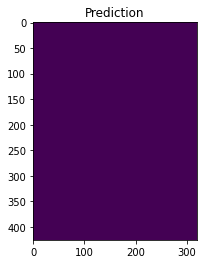

In [26]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile

PATH_TO_TEST_IMAGES_DIR= data_root+dataset+"/img_dir/val"
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/ann_dir/val"
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TEST_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

checkpoint= root_dir+'/work_dirs/tutorial/iter_19200.pth' #checkpoint path
model = init_segmentor(cfg, checkpoint, device='cuda:0')
palette = [[120, 120, 120], [6, 230, 230]] #dataset palette
print(len(TEST_IMAGE_PATHS))

for i in range(0, len(TEST_IMAGE_PATHS)):
  img = mmcv.imread(TEST_IMAGE_PATHS[i])
  label = mmcv.imread(LABEL_PATHS[i])
  result = inference_segmentor(model, img)
  img_name= LABEL_PATHS[i].split("/")[7] #FOR MASK
  # img_name= TEST_IMAGE_PATHS[i].split("/")[7] #for overlay

  #prediction mask
  arr= np.array(result)
  arr=np.squeeze(arr)

  #overlay image
  # overlay = model.show_result(img, result, palette=palette, show=False)

  # plt.subplot(1, 7 , 1)
  # plt.imshow(img)
  # plt.title("Input image")

  # plt.subplot(1, 7,  3)
  # plt.imshow(label)
  # plt.title("Ground Truth")

  # plt.subplot(1, 7,  5)
  plt.imshow(arr)
  plt.title("Prediction")

  # plt.subplot(1, 7,  7)
  # plt.imshow(mmcv.bgr2rgb(overlay))
  # plt.title("Overlay")

  # show_result_pyplot(model, img, result,palette)

  image_file_name= root_dir+"/work_dirs/results/masks/"+img_name
  plt.savefig(image_file_name)
  print("saving "+img_name)
  i= i+1

# plt.figure(figsize=(8, 6))
# show_result_pyplot(model, img, result,palette)

#Downloading Inference Results

In [28]:
from google.colab import files
#mask results
!zip -r /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks
files.download("/content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks.zip")

  adding: content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks/ (stored 0%)
  adding: content/focal_phi_loss_mmsegmentation/data/work_dirs/results/masks/val.png (deflated 20%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
#overlay results
!zip -r /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/overlays /content/focal_phi_loss_mmsegmentation/data/work_dirs/results/overlays
files.download("/content/focal_phi_loss_mmsegmentation/data/work_dirs/results/overlays.zip")

  adding: content/focal_phi_loss_mmsegmentation/data/work_dirs/results/overlays/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>